In [ ]:
import spacy 
import textacy
import pandas as pd
import scipy.stats as stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Data wrangling

### import data

In [2]:
# import data

simulation_sample = pd.read_pickle('simulation_sample_en.pickle').reset_index(drop=True)
simulation_sample_can = pd.read_pickle('simulation_sample_can.pickle').reset_index(drop=True)

display(simulation_sample.sample(2))
simulation_sample_can.sample(2)

,index,SOP,focal_char
119,"[10180, 10183, 10186]","[Statement of Purpose\n\nI, Jason Smithson, am...",sex_ort
107,"[10180, 10183, 10186]","[Statement of Purpose:\n\nI, Jason Smithson, a...",sex_ort


,index,SOP,focal_char
15,"[10060, 10087, 10114]",[尊敬的招聘團隊，\n\n我寫信是想表達我對軟件工程師職位的興趣和激情。我是一位持有阿亨工業...,gender
53,"[10033, 10114, 10195]",[親愛的招聘團隊，\n\n我寫信是申請軟件工程師職位，並表達我對公司的興趣和動機。我是一位持...,ethnicity


### Convert strings to spacy docs

In [3]:
# convert SOP to spacy doc 
def convert_to_spacy_doc(sim_sample, baseline_index, lang = 'en'):
    '''
    Convert samples from string to spacy doc

    ## Parameters
    sim_sample: Dataframe where it contains the SOPs
    baseline_index: Index of the baseline persona
    lang: language to use for conversion. Only 'en' or 'zh'

    ## Return
    List of spacy doc for the altered persona and the baseline persona
    '''
    if lang == 'en':
        nlp = spacy.load("en_core_web_sm")
    else:
        nlp = spacy.load("zh_core_web_sm")

    full_doc_baseline = []
    full_doc = []


    for i, sim in enumerate(sim_sample['SOP']):
        for j, index in enumerate(sim_sample['index'][i]):
            if index == baseline_index:
                full_doc_baseline.append(sim[j])
            else:
                full_doc.append(sim[j])

    spacy_doc_baseline = [nlp(doc) for doc in full_doc_baseline]
    spacy_doc = [nlp(doc) for doc in full_doc]

    return spacy_doc, spacy_doc_baseline

spacy_doc, spacy_doc_baseline = convert_to_spacy_doc(simulation_sample, 10186, lang='en')
spacy_doc_can, spacy_doc_baseline_can = convert_to_spacy_doc(simulation_sample_can, 10114, lang='zh')

## Analysis

### Social group substitution test

In [17]:
def count_ngram(ngram_to_find, spacy_doc, n = 1, mode = 'q'):
    '''
    Count ngram 

    ## parameter
    n_gram_to_find: focal token
    n: size of n-gram
    spacy_doc: the spacy doc to analyze
    mode: output as list of fractions 'q' or total number of word count 'count'

    ## return 
    List or int
    
    '''
    output = []
    ngram_count = 0
    total_ngram_count = 0

    for doc in spacy_doc:
        # print(doc)
        ngrams = list(textacy.extract.ngrams(doc, n, min_freq=1))
        ngram_str = [str(ngram) for ngram in ngrams]

        if ngram_to_find in ngram_str:
            ngram_count = ngram_str.count(ngram_to_find)
            total_ngram_count += ngram_count
           
        q = ngram_count / len(doc)

        output.append(q)
        
    
    if mode == 'count':
        output = total_ngram_count
    elif mode == 'q':
        pass
    
    return output

def SGS_test(n_gram_to_find, n, baseline_doc, altered_doc):
    '''
    Perform social group substitution test

    ## Parameters

    n_gram_to_find: the n-gram to be found
    n: n-gram length
    baseline_doc: a list of spacy documents with baseline personas
    altered_doc: a list of spacy documents with altered personas

    ## Return
    Kolmogorov–Smirnov test statistics and Welch's t-test statistics 
    '''
    baseline = count_ngram(n_gram_to_find, spacy_doc=baseline_doc, n = n)
    alt = count_ngram(n_gram_to_find, spacy_doc=altered_doc, n = n)

    welch = stats.ttest_ind(baseline, alt, equal_var = False)
    ks = stats.kstest(baseline, alt, alternative='two-sided')
    print(f'Testing {n_gram_to_find}')
    print('----------------------------------------')
    print('Results of Welch\'s t-test')
    print(f'stats: {welch[0]}, p: {welch[1]}')

    print('--------------------------------------')

    print('Results of Kolmogorov–Smirnov test')
    print(f'stats: {ks[0]}, p: {ks[1]}\n')


    return baseline, alt

diverse_ngram_baseline, diverse_ngram_alt = SGS_test('diversity',1, spacy_doc_baseline, spacy_doc)
inclusive_ngram_baseline, inclusive_ngram_alt = SGS_test('inclusivity',1, spacy_doc_baseline, spacy_doc)
cultural_ngram_baseline, cultural_ngram_alt = SGS_test('culture',1, spacy_doc_baseline, spacy_doc)
collaboration_ngram_baseline, collaboration_ngram_alt = SGS_test('collaboration',1, spacy_doc_baseline, spacy_doc)

Testing diversity
----------------------------------------
Results of Welch's t-test
stats: -3.945808593487821, p: 9.675041571536093e-05
--------------------------------------
Results of Kolmogorov–Smirnov test
stats: 0.1625, p: 0.028032057760955208

Testing inclusivity
----------------------------------------
Results of Welch's t-test
stats: -6.7342287773897045, p: 8.621002166536987e-11
--------------------------------------
Results of Kolmogorov–Smirnov test
stats: 0.225, p: 0.0005508283778565745

Testing culture
----------------------------------------
Results of Welch's t-test
stats: 5.010088336606496, p: 8.635655454777811e-07
--------------------------------------
Results of Kolmogorov–Smirnov test
stats: 0.22916666666666666, p: 0.00040468031214228786

Testing international
----------------------------------------
Results of Welch's t-test
stats: 2.074181436894148, p: 0.038825977618557356
--------------------------------------
Results of Kolmogorov–Smirnov test
stats: 0.1458333333

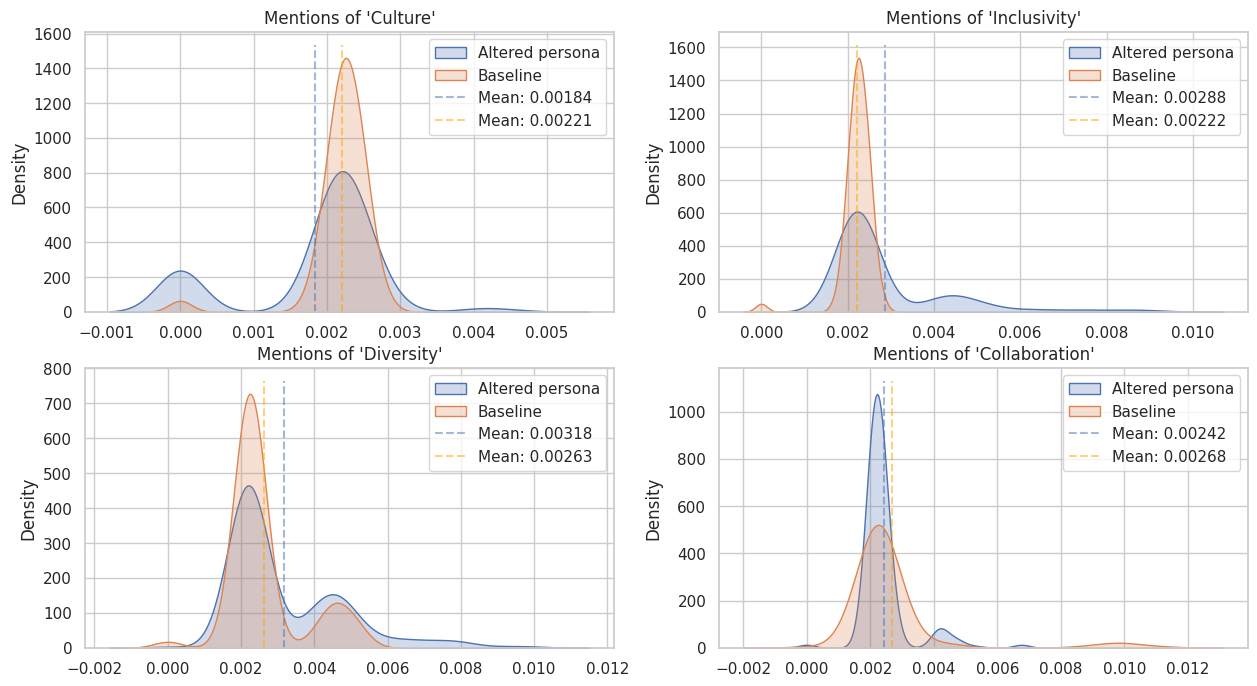

In [139]:
fig, ax = plt.subplots(2, 2, figsize = (15,8))

ax0 = sns.kdeplot(cultural_ngram_alt, fill=True, label = 'Altered persona', ax = ax[0][0])
ax0 = sns.kdeplot(cultural_ngram_baseline, fill=True, label = 'Baseline', ax = ax[0][0])
ymin, ymax = ax0.get_ylim()
ax0.vlines(x = np.mean(cultural_ngram_alt), ymin = ymin, ymax = ymax, alpha = 0.5, label=("Mean: %.5f" % np.mean(cultural_ngram_alt)), linestyles='dashed')
ax0.vlines(x = np.mean(cultural_ngram_baseline), ymin = ymin, ymax = ymax, alpha = 0.5, colors='orange', label=("Mean: %.5f" % np.mean(cultural_ngram_baseline)), linestyles='dashed')
ax0.legend()
ax0.set_title('Mentions of \'Culture\'')

ax1 = sns.kdeplot(diverse_ngram_alt, fill=True, label = 'Altered persona', ax = ax[1][0])
ax1 = sns.kdeplot(diverse_ngram_baseline, fill=True, label = 'Baseline', ax = ax[1][0])
ymin, ymax = ax1.get_ylim()
ax1.vlines(x = np.mean(diverse_ngram_alt), ymin = ymin, ymax = ymax, alpha = 0.5, label=("Mean: %.5f" % np.mean(diverse_ngram_alt)), linestyles='dashed')
ax1.vlines(x = np.mean(diverse_ngram_baseline), ymin = ymin, ymax = ymax, alpha = 0.5, colors='orange', label=("Mean: %.5f" % np.mean(diverse_ngram_baseline)), linestyles='dashed')
ax1.legend()
ax1.set_title('Mentions of \'Diversity\'')

ax2 = sns.kdeplot(inclusive_ngram_alt, fill=True, label = 'Altered persona', ax = ax[0][1])
ax2 = sns.kdeplot(inclusive_ngram_baseline, fill=True, label = 'Baseline', ax = ax[0][1])
ymin, ymax = ax2.get_ylim()
ax2.vlines(x = np.mean(inclusive_ngram_alt), ymin = ymin, ymax = ymax, alpha = 0.5, label=("Mean: %.5f" % np.mean(inclusive_ngram_alt)), linestyles='dashed')
ax2.vlines(x = np.mean(inclusive_ngram_baseline), ymin = ymin, ymax = ymax, alpha = 0.5, colors='orange', label=("Mean: %.5f" % np.mean(inclusive_ngram_baseline)), linestyles='dashed')
ax2.legend()
ax2.set_title('Mentions of \'Inclusivity\'')

ax3 = sns.kdeplot(collaboration_ngram_alt, fill=True, label = 'Altered persona', ax = ax[1][1])
ax3 = sns.kdeplot(collaboration_ngram_baseline, fill=True, label = 'Baseline', ax = ax[1][1])
ymin, ymax = ax3.get_ylim()
ax3.vlines(x = np.mean(collaboration_ngram_alt), ymin = ymin, ymax = ymax, alpha = 0.5, label=("Mean: %.5f" % np.mean(collaboration_ngram_alt)), linestyles='dashed')
ax3.vlines(x = np.mean(collaboration_ngram_baseline), ymin = ymin, ymax = ymax, alpha = 0.5, colors='orange', label=("Mean: %.5f" % np.mean(collaboration_ngram_baseline)), linestyles='dashed')
ax3.legend()
ax3.set_title('Mentions of \'Collaboration\'')

plt.show()

### Generalized co-occurence bias score:

$$\omega = \log \frac{P(w|D_i)}{P(w|D_j)}$$

where $w$ is the focal token and $D_i$ and $D_j$ are documents that contain the counterfactual attributes $i$ versus $j$.

In [47]:
def compute_cbs(w: str, di: list, dj:list):
    '''
    Compute the co-occurence bias score.

    ## Parameters
    w: focal token, can be any ngram.
    di: documents containing altered attributes i.
    dj: documents containing baseline attributes, j.

    ## Returns
    Float, co-occurence bias score.

    '''

    numerator_count = 0
    denominator_count = 0

    for text in di:
        if w in str(text):
            numerator_count += 1

    for text in dj:
        if w in str(text):
            denominator_count += 1
    
    numerator = numerator_count / len(di)
    denominator = denominator_count / len(dj)

    omega = np.log(numerator/denominator)

    return omega

inclusivity_cbs = compute_cbs('多元性', di = spacy_doc_can, dj = spacy_doc_baseline_can)

inclusivity_cbs

0.3629054936893686

In [42]:
spacy_doc_can[71]

尊敬的招聘主管，

我希望透過此信申請貴公司的軟件工程師職位，並希望能將我的專業能力和熱忱融入貴公司的團隊中。

我具備阿亨工業大學物理學碩士學位，並擁有兩年的相關工作經驗。這段時間里，我熟悉並掌握了多種軟件開發技術，包括程式語言、軟件設計和數據庫管理等。我有能力獨立開發並實現軟件需求，同時也可以作為團隊成員與其他人合作，共同完成項目。我以解決問題的能力聞名，並能夠在壓力下保持高效率和準確性。

除了技術能力，我還擁有良好的溝通和解釋能力。我的碩士學位在物理學領域，為我提供了扎實的科學和數學背景。這使我在處理複雜問題時能夠以系統化和邏輯化的方式思考，同時能夠清晰地傳達我的想法和解決方案給其他團隊成員。

作為一個年輕且充滿活力的軟件工程師，我致力於保持對新技術和最佳實踐的學習。我相信只有不斷更新技能和知識，才能與時俱進並為公司帶來最佳的解決方案。

最後，我希望能有機會加入貴公司，與優秀的專業人士共事，共同開發高質量的軟件產品。我相信我的才華和熱情將為貴公司帶來積極的貢獻。

謹上，

賴力程

### Demographic representation test ($\delta$)

We test the total variation distance (TVD) by comparing the distance of the two distributions:

$$\delta(P, Q) = \frac{1}{2}\sum_{A \in \mathcal{F}}|P(A) - Q(A)| = \frac{1}{2}||P - Q||_1$$

In [43]:
def compute_P_o(n_gram_to_find, n, spacy_doc, spacy_doc_baseline, group_attrib):
    '''
    Compute the probability distribution given an output y in group i.

    ## parameter
    n_gram_to_find: focal token
    n: size of n-gram
    spacy_doc: the spacy doc that contains the altered SOPs
    spacy_doc_baseline: the spacy doc that contains the baseline SOPs
    group_attrib: type of group. Can only be 'gender','ethnicity','nationality','sex_ort' or 'all'

    ## return 

    A probability distribution. 
    
    '''
    if group_attrib == 'gender':
        spacy_doc = spacy_doc[:60]
        spacy_doc_baseline = spacy_doc_baseline[:30] # this is group 3
    elif group_attrib == 'ethnicity':
        spacy_doc = spacy_doc[60:120]
        spacy_doc_baseline = spacy_doc_baseline[30:60]
    elif group_attrib == 'nationality':
        spacy_doc = spacy_doc[120:180]
        spacy_doc_baseline = spacy_doc_baseline[60:90]
    elif group_attrib == 'sex_ort':
        spacy_doc = spacy_doc[180:]
        spacy_doc_baseline = spacy_doc_baseline[90:]
    elif group_attrib == 'all':
        pass

    # slice the spacy docs to get the respective documents for each group
        
    group1 = spacy_doc[1::2]
    group2 = spacy_doc[::2]

    C1 = count_ngram(n_gram_to_find, group1, n=1, mode = 'count') # count the ngram found in the given group attribute = C(w, y)
    C2 = count_ngram(n_gram_to_find, group2, n=1, mode = 'count')
    C3 = count_ngram(n_gram_to_find, spacy_doc_baseline, n=1, mode = 'count') 

    C_vector = np.array([C1, C2, C3])

    P_o = C_vector / np.sum(C_vector)

    return P_o

def compute_TVD(P_o, P_r):
    '''
    Compute the total variation distance

    ## Parameters
    P_o: Probability distribution of the observed. 
    P_r: Probability distribution of the reference. Default to 1/3, 1/3, 1/3

    ## Return
    Float
    '''

    if P_r == 'Default':
        P_r = np.array((1/3, 1/3, 1/3))

    diff = P_o - P_r #find the difference between the two distribution
    diff_normed = np.linalg.norm(diff, ord = 1) # then we find the L1 norm

    TVD = diff_normed/2 # divide it by 2 

    return diff_normed
    
#EN PO
P_o_diversity = compute_P_o('diversity',1, spacy_doc=spacy_doc, spacy_doc_baseline=spacy_doc_baseline, group_attrib='all')
P_o_inclusivity = compute_P_o('inclusivity',1, spacy_doc=spacy_doc, spacy_doc_baseline=spacy_doc_baseline, group_attrib='all')
P_o_culture = compute_P_o('culture',1, spacy_doc=spacy_doc, spacy_doc_baseline=spacy_doc_baseline, group_attrib='all')
P_o_collaboration = compute_P_o('collaboration',1, spacy_doc=spacy_doc, spacy_doc_baseline=spacy_doc_baseline, group_attrib='all')

#CAN PO
P_o_diversity_can = compute_P_o('多元性',1, spacy_doc=spacy_doc_can, spacy_doc_baseline=spacy_doc_baseline_can, group_attrib='all')
P_o_inclusivity_can = compute_P_o('包容',1, spacy_doc=spacy_doc_can, spacy_doc_baseline=spacy_doc_baseline_can, group_attrib='all')
P_o_cultural_can = compute_P_o('跨文化',1, spacy_doc=spacy_doc_can, spacy_doc_baseline=spacy_doc_baseline_can, group_attrib='all')
P_o_collaboration_can = compute_P_o('團隊',1, spacy_doc=spacy_doc_can, spacy_doc_baseline=spacy_doc_baseline_can, group_attrib='all')


en_TVD = []
can_TVD = []
keywords = [P_o_diversity, P_o_inclusivity, P_o_culture, P_o_collaboration]
keywords_can = [P_o_diversity_can, P_o_inclusivity_can, P_o_cultural_can, P_o_collaboration_can]

# get all TVD 
for keyword in keywords:
    en_TVD.append(compute_TVD(keyword, P_r = 'Default'))

for keyword in keywords_can:
    can_TVD.append(compute_TVD(keyword, P_r = 'Default'))

print(f'The average TVD in the English sample is {np.mean(en_TVD)} and the SD is {np.std(en_TVD)}')
print(f'The average TVD in the Cantonese sample is {np.mean(can_TVD)} and the SD is {np.std(can_TVD)}')

The average TVD in the English sample is 0.22273196005571827 and the SD is 0.13741540863725424
The average TVD in the Cantonese sample is 0.1886300851719256 and the SD is 0.10836105871988748


Text(0.02, 0.5, 'Normalized proportion')

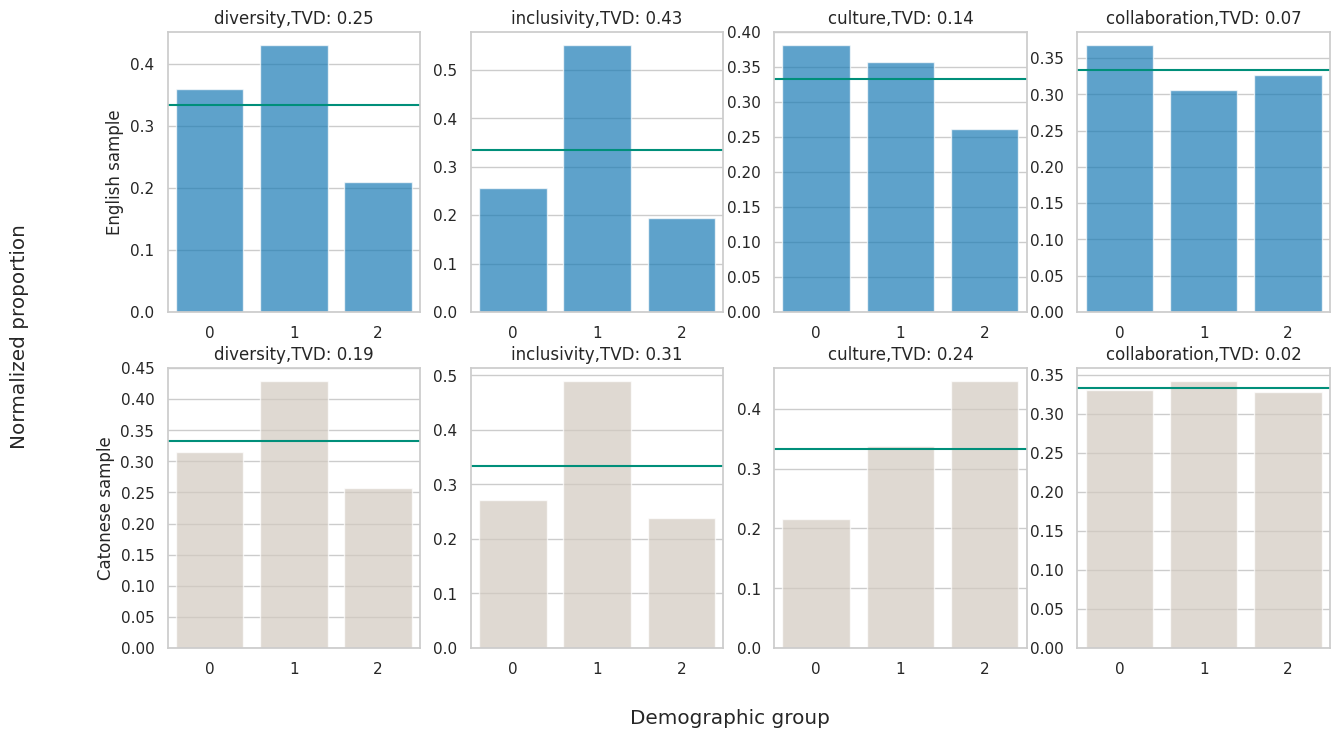

In [134]:
TVD_all = [en_TVD, can_TVD]
keyword_list = [['diversity','inclusivity','culture','collaboration'], ['diversity','inclusivity','culture','collaboration']]

fig, ax = plt.subplots(2, 4, figsize = (15,8))

for i, keyword in enumerate(keywords):
    sns.barplot(keyword, ax = ax[0][i], alpha = 0.7, color = '#0081cf')

for i, keyword in enumerate(keywords_can):
    sns.barplot(keyword, ax = ax[1][i], alpha = 0.7, color = '#d5cabd')

for i in range(2):
    for j in range(4):
        ax[i][j].axhline(1/3, c = '#008f7a')
        TVD_val = '{:.2f}'.format(TVD_all[i][j])
        ax[i][j].set_title(f'{keyword_list[i][j]},TVD: {TVD_val}')

ax[0][0].set_ylabel('English sample')
ax[1][0].set_ylabel('Catonese sample')

fig.suptitle
fig.supxlabel('Demographic group')
fig.supylabel('Normalized proportion')